# Problem 0: Other activation functions (10%)

### The leaky Relu is defined as $max(0.1x, x)$.
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?

---

**ANSWERS**

1) The derivative of the leaky ReLU function can be expressed as:

   f′(x)=0.1x if x＜0

   f′(x)=x if x＞0

2) Yes, leaky ReLU is suitable for backpropagation. Its derivative is simple and computationally efficient, allowing for effective gradient flow 
during training, especially in deep networks where traditional ReLU might fail due to the dying ReLU issue.

### $tanh$ is defined as $\frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$
 - What is its derivative? (Please express in "easy" format")
 - Is it suitable for back propagation?
 - How is it different from the sigmoid activation
 - What is an example of when to use it? When should you not use it?

----
**ANSWERS**

1) The derivative of the tanh function can be derived and simplified to:
 
   f′(x)=1−tanh^2(x)

2) Yes, the tanh function is suitable for backpropagation. Its derivative is straightforward to compute, and the function itself is differentiable everywhere, which is crucial for gradient-based optimization methods.

3) Difference from Sigmoid Activation:
   - Range: The tanh function outputs values between -1 and 1, making it zero-centered. In contrast, the sigmoid function outputs values between 0 and 1.
   - Gradient: Tanh has a stronger gradient for most inputs compared to the sigmoid function, which can be beneficial for learning but also makes it more prone to the vanishing gradient problem in very deep networks.

4) Use tanh in hidden layers of neural networks where you need a non-linear activation function that is zero-centered, which can help in stabilizing the learning process.
Avoid using tanh in very deep networks or when dealing with problems where the vanishing gradient problem might be a significant issue. In such cases, ReLU or its variants (like leaky ReLU) might be more appropriate. Additionally, for binary classification problems where the output needs to be interpreted as a probability, the sigmoid function is typically preferred.

# Problem 1: The Deep Learning Recipe (40%)

In this problem, we'll follow the "deep learning recipe" covered in class on the IMDB data.

In [182]:
import numpy as np
import pandas as pd
import glob
import os
%pylab inline
np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Step 0: load the data

In [183]:
import os
import glob

def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    """Provided helper function to load data"""
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [184]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


Steps 
 - be one with data
 - set up e2e harness + get dumb baselines
 - overfit
 - regualarize
 - tune
 - squeeze

### Step 1: be one with the data
 - make some histograms
 - calculate some summary statistics
 - read a bunch of training examples and discuss any oddities you find
 - finally, turn the data into count vectors

In [185]:
# your code here
# make some plots, calculate some summary stats
import matplotlib.pyplot as plt

def analyze_text_lengths(docs):
    lengths = [len(doc.split()) for doc in docs]
    return {
        'mean_length': np.mean(lengths),
        'median_length': np.median(lengths),
        'std_length': np.std(lengths),
        'min_length': min(lengths),
        'max_length': max(lengths),
        'total_words': sum(lengths)
    }
    
def plot_histograms(train_lengths: list, test_lengths: list):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(train_lengths, bins=50, color='blue', alpha=0.7)
    plt.title('Training Document Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(test_lengths, bins=50, color='green', alpha=0.7)
    plt.title('Test Document Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def find_anomalies(docs: list, min_length: int = 15, max_length: int = 1500):
    anomalies = []
    for i, doc in enumerate(docs):
        length = len(doc.split())
        if length < min_length or length > max_length:
            anomalies.append((i, doc))
    return anomalies

In [186]:
train_stats = analyze_text_lengths(train_docs)
test_stats = analyze_text_lengths(test_docs)
print('train stats:', train_stats)
print('test stats:', test_stats)

train stats: {'mean_length': 233.7872, 'median_length': 174.0, 'std_length': 173.72955740506563, 'min_length': 10, 'max_length': 2470, 'total_words': 5844680}
test stats: {'mean_length': 228.52668, 'median_length': 172.0, 'std_length': 168.88031504049724, 'min_length': 4, 'max_length': 2278, 'total_words': 5713167}


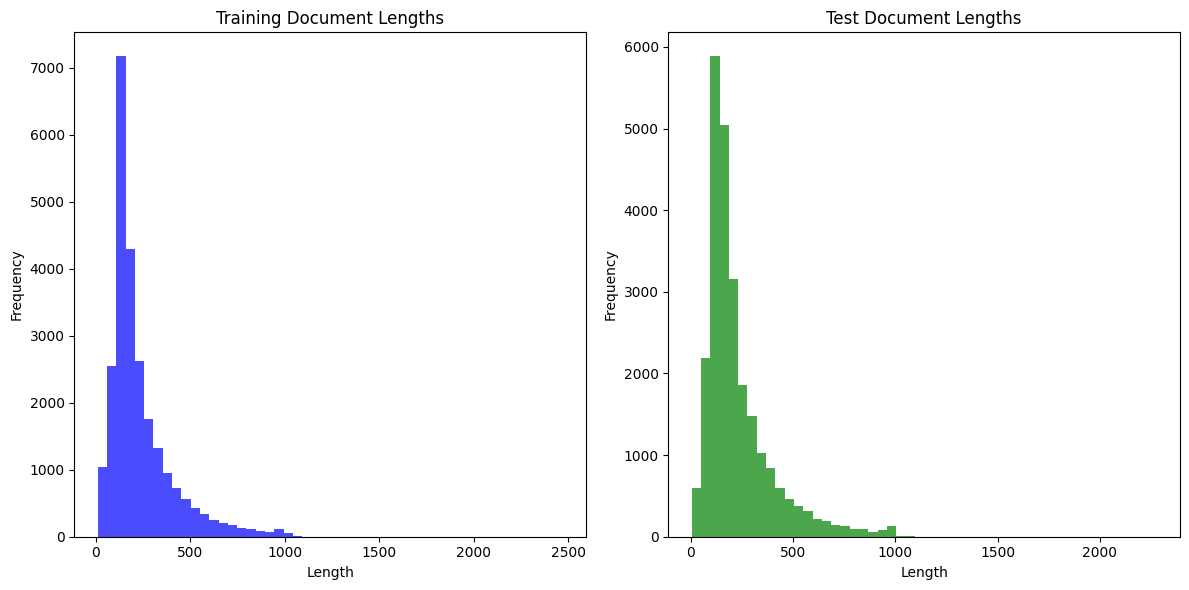

In [187]:
train_lengths = [len(doc.split()) for doc in train_docs]
test_lengths = [len(doc.split()) for doc in test_docs]
plot_histograms(train_lengths, test_lengths)

In [188]:
# your code here
# print out some documents, find some anomalies
anomalies = find_anomalies(train_docs)
print("Anomalies found:")
for idx, doc in anomalies:
    print(f"Document {idx}: {doc}")

Anomalies found:
Document 1632: This movie is terrible but it has some good effects.
Document 6939: You'd better choose Paul Verhoeven's even if you have watched it.
Document 8655: Ming The Merciless does a little Bardwork and a movie most foul!
Document 15726: Warning: Does contain spoilers.<br /><br />Open Your Eyes<br /><br />If you have not seen this film and plan on doing so, just stop reading here and take my word for it. You have to see this film. I have seen it four times so far and I still haven't made up my mind as to what exactly happened in the film. That is all I am going to say because if you have not seen this film, then stop reading right now.<br /><br />If you are still reading then I am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think.<br /><br />I remember my Grade 11 English teacher quite well. His name was Mr. Krisak. To me, he was wise beyond his years and he always had this circuitous way of t

In [189]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(lowercase=True, max_features=50000)
vec.fit(train_docs)
term_document_matrix_train = vec.transform(train_docs)
term_document_matrix_test = vec.transform(test_docs)
print(term_document_matrix_train.shape, term_document_matrix_test.shape)

(25000, 50000) (25000, 50000)


## Step 2: set up test harness and get baselines
 - state your baseline models and calculate the log loss and accuracy
   - what is the best constant guess?
   - what about a rules-based model? (e.g. checking if one of a few known words is present)
 - make a function that calculates model performance on the test set
   - `def eval_model(your_model):`
 - make a keras model
   - try to initialize the last layer appropriately (see [here](https://keras.io/api/layers/initializers/))
     - `bias_initializer=Constant(some_constant)`
   - evaluate the model with your function BEFORE training
 - examine data exactly as it is presented to the network
 - make sure you can memorize a batch

In [190]:
from sklearn.metrics import log_loss, accuracy_score

In [191]:
# Calculate the accuracy and log loss for a constant guess
constant_guess = np.ones_like(y_test) * np.mean(y_train)
constant_log_loss = log_loss(y_test, constant_guess)
constant_accuracy = accuracy_score(y_test, np.round(constant_guess))
print(f'Constant guess log loss: {constant_log_loss}')
print(f'Constant guess accuracy: {constant_accuracy}')

Constant guess log loss: 0.6931471805599453
Constant guess accuracy: 0.5


In [192]:
# Calculate the accuracy and log loss for a rules-based approach
def rules_based_model(docs):
    predictions = []
    for doc in docs:
        if 'good' in doc or 'excellent' in doc:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

rules_based_predictions = rules_based_model(test_docs)
rules_based_log_loss = log_loss(y_test, rules_based_predictions)
rules_based_accuracy = accuracy_score(y_test, rules_based_predictions)
print(f'Rules-based model log loss: {rules_based_log_loss}')
print(f'Rules-based model accuracy: {rules_based_accuracy}')

Rules-based model log loss: 17.35429823379212
Rules-based model accuracy: 0.51852


In [193]:
def eval_model(model):
    # your code here
    # print or return the accuracy and log loss on the test data
    predictions = model.predict(term_document_matrix_test)
    log_loss_value = log_loss(y_test, predictions)
    accuracy_value = accuracy_score(y_test, np.round(predictions))
    print(f'Model log loss: {log_loss_value}')
    print(f'Model accuracy: {accuracy_value}')

In [194]:
# some other keras imports
import keras.backend as K
from keras.initializers import Constant # for last layer initialization
from keras.models import Model
from keras.layers import Dense, Input

hint: what value of X do I need for $\sigma(x)$ to be 0.5

In [195]:
# make a model
# inpt = Input(shape=...)
# hidden = ... (inpt)
# hidden = ...(hidden)
# ...
# model = ...
# model.compile... # don't forget to compile it

K.clear_session()
text_input = Input(shape=(term_document_matrix_train.shape[1],))
hidden_state_1 = Dense(8, activation="relu")(text_input)
hidden_state_2 = Dense(8, activation="relu")(hidden_state_1)
output = Dense(1, activation="sigmoid")(hidden_state_2)

model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       400,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,089 (1.53 MB)

 Trainable params: 400,089 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [196]:
# evaluate the model before training it
eval_model(model)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model log loss: 0.6935904376604634
Model accuracy: 0.50476


In [197]:
# examine data as it is presented to the network
print("Example training data (vectorized):")
print(term_document_matrix_train[0].toarray())
print("Corresponding document:")
print(train_docs[0])

Example training data (vectorized):
[[0 0 0 ... 0 0 0]]
Corresponding document:
My wife and I took our 13 year old son to see this film and were absolutely delighted with the winsome fun of the film. It has extra appeal to boys and men who remember their childhood, but even women enjoy the film and especially Hallie Kate Eisenberg's refrain, "Boys are so weird." It's refreshing to see a film that unapologetically shows that boys and girls are indeed different in their emotional and social makeup. Boys really do these kinds of strange things and usually survive to tell the story and scare their mothers silly! We enjoyed the film so much that my son and an 11 year old friend, myself and my daughters 23 year old boyfriend went to see the movie the next day for a guys day out. We had even more fun the second time around and everyone raved about it. It's clean and delightfully acted by a pre-adolescent cast reminiscent of the TV Classic "Freaks and Geeks". We all feel it will become a sleep

In [198]:
# your code here
# print out a few training examples
# they should be vectors of counts.
# turn them back into words
for i in range(5):
    print(f"Training example {i}:")
    print(term_document_matrix_train[i].toarray())
    print("Corresponding document:")
    print(train_docs[i])
    print()

Training example 0:
[[0 0 0 ... 0 0 0]]
Corresponding document:
My wife and I took our 13 year old son to see this film and were absolutely delighted with the winsome fun of the film. It has extra appeal to boys and men who remember their childhood, but even women enjoy the film and especially Hallie Kate Eisenberg's refrain, "Boys are so weird." It's refreshing to see a film that unapologetically shows that boys and girls are indeed different in their emotional and social makeup. Boys really do these kinds of strange things and usually survive to tell the story and scare their mothers silly! We enjoyed the film so much that my son and an 11 year old friend, myself and my daughters 23 year old boyfriend went to see the movie the next day for a guys day out. We had even more fun the second time around and everyone raved about it. It's clean and delightfully acted by a pre-adolescent cast reminiscent of the TV Classic "Freaks and Geeks". We all feel it will become a sleeper hit not unlik

In [199]:
# make sure you can "memorize" or complete fit a small batch of data
# try the first 100 training examples
# the loss should go to near 0 pretty quickly
#model.fit(...)
model.fit(term_document_matrix_train[:100], 
          y_train[:100], 
          epochs=15,
          batch_size=512,
          validation_data=(term_document_matrix_test, y_test), 
          verbose=1)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.6000 - loss: 0.6840 - val_acc: 0.5043 - val_loss: 0.6935
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.6700 - loss: 0.6509 - val_acc: 0.5026 - val_loss: 0.6972
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.6900 - loss: 0.6140 - val_acc: 0.5057 - val_loss: 0.6936
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.8400 - loss: 0.5716 - val_acc: 0.5107 - val_loss: 0.6885
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.9200 - loss: 0.5331 - val_acc: 0.5108 - val_loss: 0.6894
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.9600 - loss: 0.4971 - val_acc: 0.5069 - val_loss: 0.6992
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.9700 - loss: 0.4626 - val_acc: 0.5048 - val_loss: 0.7114
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.9700 - loss: 0.4314 - val_acc: 0.5043 - val_loss: 0.7218
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.9800 - loss: 0.4024 - val_acc: 0.5044 - 

In [200]:
eval_model(model)
# at this point, the model is probably over fit

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model log loss: 0.7906306528667495
Model accuracy: 0.50644


## Part 3:  Overfit
 - make the network large, and convince yourself you can overfit the data

In [201]:
# your code here
K.clear_session()
text_input = Input(shape=(term_document_matrix_train.shape[1],))
hidden_state_1 = Dense(256, activation="relu")(text_input)
hidden_state_2 = Dense(128, activation="relu")(hidden_state_1)
output = Dense(1, activation="sigmoid")(hidden_state_2)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,800,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,833,281 (48.96 MB)

 Trainable params: 12,833,281 (48.96 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
# fit the model
#model.fit(...)
model.fit(term_document_matrix_train, 
          y_train, 
          epochs=5,
          batch_size=512,
          validation_data=(term_document_matrix_test, y_test), 
          verbose=1)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - acc: 0.7756 - loss: 0.4684 - val_acc: 0.8724 - val_loss: 0.3330
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - acc: 0.9601 - loss: 0.1202 - val_acc: 0.8590 - val_loss: 0.4248
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - acc: 0.9874 - loss: 0.0507 - val_acc: 0.8644 - val_loss: 0.4900
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - acc: 0.9955 - loss: 0.0191 - val_acc: 0.8626 - val_loss: 0.6029
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - acc: 0.9993 - loss: 0.0050 - val_acc: 0.8602 - val_loss: 0.6944


## Part 4: Regularize
 - use regularizers, dropout, network size, etc

In [203]:
from tensorflow.keras.regularizers import l2, l1, l1_l2
from keras.layers import Dropout

In [204]:
# model code here
# just like you did in the previous part
# add dropout, regularization, maybe remove a Dense layer
K.clear_session()
text_input = Input(shape=(term_document_matrix_train.shape[1],))
hidden_state = Dense(
    32,
    activation="relu",
    kernel_regularizer=l2(1e-4),
)(text_input)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(
    16,
    activation="relu",
)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(1, activation="sigmoid")(hidden_state)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,577 (6.11 MB)

 Trainable params: 1,600,577 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
# fit the model
model.fit(term_document_matrix_train, 
          y_train, 
          epochs=5,
          batch_size=512,
          validation_data=(term_document_matrix_test, y_test), 
          verbose=1)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - acc: 0.7088 - loss: 0.5847 - val_acc: 0.8673 - val_loss: 0.3657
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - acc: 0.9027 - loss: 0.3049 - val_acc: 0.8843 - val_loss: 0.3170
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - acc: 0.9455 - loss: 0.1998 - val_acc: 0.8857 - val_loss: 0.3210
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - acc: 0.9651 - loss: 0.1480 - val_acc: 0.8760 - val_loss: 0.3671
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - acc: 0.9800 - loss: 0.1091 - val_acc: 0.8756 - val_loss: 0.4028


## Part 5 - 6: Tune and Squeeze
It will take a long time to tune the number of units in the Dense layers, so we will skip the tune phase. 

### Todo
 - Retrain the model
 - Make sure let it train enough
 - use callbacks to make sure the network stops before overfitting too much 
 - use callbacks to reduce the learning rate appropriately. 

In [206]:
# model code here
K.clear_session()
text_input = Input(shape=(term_document_matrix_train.shape[1],))
hidden_state = Dense(
    32,
    activation="relu",
    kernel_regularizer=l2(1e-4),
)(text_input)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(
    16,
    activation="relu",
)(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
output = Dense(1, activation="sigmoid")(hidden_state)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,577 (6.11 MB)

 Trainable params: 1,600,577 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [207]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
# add these callbacks just like we did in class

In [208]:
# fit the model
lr = ReduceLROnPlateau(patience=1, verbose=True)
es = EarlyStopping(patience=2, verbose=True)

model.fit(
    term_document_matrix_train,
    y_train,
    epochs=30,
    batch_size=512,
    validation_data=(term_document_matrix_test, y_test),
    callbacks=[lr, es]
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - acc: 0.7098 - loss: 0.5891 - val_acc: 0.8756 - val_loss: 0.3516 - learning_rate: 0.0010
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - acc: 0.9103 - loss: 0.2834 - val_acc: 0.8889 - val_loss: 0.3049 - learning_rate: 0.0010
Epoch 3/30
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.9518 - loss: 0.1767
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - acc: 0.9517 - loss: 0.1766 - val_acc: 0.8848 - val_loss: 0.3286 - learning_rate: 0.0010
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.9722 - loss: 0.1205
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - acc: 0.9722 - loss: 0.1206 - val_acc: 0.8860 - val_loss: 0.3317 - learning_rate: 1.0000e-04
Epoch 4: early stopping


In [209]:
eval_model(model)
# you should be able to get > 88% accuracy

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Model log loss: 0.31718860503451907
Model accuracy: 0.88596


# Problem 2: Transfer Learning (30 %)

In this problem we will explore a technique called transfer learning. Often, we don't have very much labeled data for the problem at hand (we call it __data-poor__), but we can find labeled data for a similar problem (which we call ___data-rich__). 

In transfer learning, we use the __data-rich problem__ to train an network with good performance. We then make a similar network for the __data-poor problem__ but use the weights learned from the first problem in this network. This greatly reduces the amount of data needed to train the data-poor problem. You can think of this as reducing the number of free parameters. 

Here, we will use the mnist digit recognition problem. We will pretend that we are interested in telling the difference between the digits `4` and `9`, but we only have 10 labeled examples. We will pretend that we have tons of labeled examples of all of the other digits. 

In [210]:
import numpy as np
import pandas as pd
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [211]:
# add some imports
from keras.utils import to_categorical
from keras.datasets import mnist
np.random.seed(1234)

## Part 0: Subset the data into two datasets
 1. One part will have `x_train_49`, `y_train_49`, etc. which has only `4`s and `9`s. 
 2. The second part will have variables `x_train_rest` etc, which will have the rest of the data and none of the digits `4` and `9`. 

In [212]:
def preprocess_training_data(data):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    data = data.astype('float32') / 255
    return data

def preprocess_targets(target, num_classes):
    return to_categorical(target, num_classes)


def subset_to_9_and_4(x, y):  # this is a new function
    mask = (y == 9) | (y == 4)
    new_x = x[mask]
    new_y = (y[mask] == 4).astype('int64')
    return new_x, new_y

def subset_to_rest(x, y):  # this is a new function
    mask = ~((y == 9) | (y == 4))
    new_x = x[mask]
    new_y = y[mask]
    return new_x, new_y

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = preprocess_training_data(x_train)
x_test = preprocess_training_data(x_test)

num_classes = np.unique(y_train).shape[0]

y_train_ohe = preprocess_targets(y_train, num_classes)
y_test_ohe = preprocess_targets(y_test, num_classes)

train_frac = 0.8
cutoff = int(x_train.shape[0] * train_frac)
x_train, x_val = x_train[:cutoff], x_train[cutoff:]
y_train, y_val = y_train[:cutoff], y_train[cutoff:]
y_train_ohe, y_val_ohe = y_train_ohe[:cutoff], y_train_ohe[cutoff:]

x_train_49, y_train_49 = subset_to_9_and_4(x_train, y_train)
x_val_49, y_val_49 = subset_to_9_and_4(x_val, y_val)
x_test_49, y_test_49 = subset_to_9_and_4(x_test, y_test)

print(x_train_49.shape)

x_train_rest, y_train_rest = subset_to_rest(x_train, y_train)
x_test_rest, y_test_rest = subset_to_rest(x_test, y_test)

y_train_rest_ohe = to_categorical(y_train_rest, num_classes)
y_test_rest_ohe = to_categorical(y_test_rest, num_classes)

(9457, 784)


In [213]:
print(y_train_rest_ohe[0])
print(y_train_rest[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5


In [214]:
# show distinct classes in x_train_rest
print(np.unique(y_train_rest))

[0 1 2 3 5 6 7 8]


## Now we will throw away most of the training data for the 4-9 problem
 - we will keep only 10 points

In [215]:
num_points = 10
x_train_49, y_train_49 = x_train_49[:num_points], y_train_49[:num_points]

## Part 1: Build a neural network to fit the `rest` data.
 - Include 2 densely connected hidden layers with 256 neurons each.
 - The output dimension should be either 8 or 10, depending on how you do the problem
 - Compute the accuracy score for this model

In [216]:
K.clear_session()
num_hidden_units = 256

In [217]:
digit_input = Input(shape=(x_train_rest.shape[1],), name='digit_input')
# add code here
#model_rest = ...
#model_rest.compile( ... # to be removed
hidden_1 = Dense(num_hidden_units, activation='relu')(digit_input)
hidden_2 = Dense(num_hidden_units, activation='relu')(hidden_1)
output = Dense(num_classes, activation='softmax')(hidden_2)

model_rest = Model(digit_input, output)
model_rest.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_rest.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digit_input (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the model for 10 epochs and compute the accuracy score

In [218]:
from sklearn.metrics import accuracy_score

#model_rest.fit(...
model_rest.fit(x_train_rest, 
               y_train_rest_ohe, 
               epochs=10, 
               batch_size=512, 
               validation_data=(x_test_rest, y_test_rest_ohe), 
               verbose=1)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7527 - loss: 0.8757 - val_accuracy: 0.9474 - val_loss: 0.1792
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9546 - loss: 0.1556 - val_accuracy: 0.9640 - val_loss: 0.1226
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9707 - loss: 0.0998 - val_accuracy: 0.9690 - val_loss: 0.0978
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9792 - loss: 0.0748 - val_accuracy: 0.9735 - val_loss: 0.0859
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9830 - loss: 0.0610 - val_accuracy: 0.9742 - val_loss: 0.0862
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0470 - val_accuracy: 0.9767 - val_loss: 0.0725
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0352 - val_accuracy: 0.9789 - val_loss: 0.0714
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0274 - val_accuracy: 0.9803 - val_loss:

In [219]:
#accuracy_score(...
# Compute accuracy on rest data
train_acc = model_rest.evaluate(x_train_rest, y_train_rest_ohe, verbose=0)[1]
test_acc = model_rest.evaluate(x_test_rest, y_test_rest_ohe, verbose=0)[1]
print(f'Training accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Training accuracy: 0.9982616901397705
Test accuracy: 0.9821450710296631


## Part 2: Fit a model on the `4`-`9` data
 - ### Use the same 2 densely-connected layers with 256 hidden units
 - ### Here the output layer could have 1 or two units, depending on how you set up the problem
 - ### NB: DO NOT use `K.clear_session()` because we need stuff for later. 

In [220]:
digit_input_49 = Input(shape=(x_train_49.shape[1],), name='digit_input')
# add code here
#model49 = Model(...
#model49.compile( ...
hidden_1 = Dense(256, activation='relu')(digit_input_49)
hidden_2 = Dense(256, activation='relu')(hidden_1)
output = Dense(1, activation='sigmoid')(hidden_2)

model49 = Model(digit_input_49, output)
model49.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model49.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digit_input (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,009 (1.02 MB)

 Trainable params: 267,009 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [221]:
#model49.fit( ... (NB try epochs=1000)
model49.fit(
    x_train_49, 
    y_train_49, 
    epochs=1000, 
    batch_size=512, 
    validation_data=(x_val_49, y_val_49), 
    verbose=1
)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.4000 - loss: 0.6950 - val_accuracy: 0.5681 - val_loss: 0.6633
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9000 - loss: 0.4835 - val_accuracy: 0.5737 - val_loss: 0.6502
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.3439 - val_accuracy: 0.5848 - val_loss: 0.6410
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.2442 - val_accuracy: 0.6058 - val_loss: 0.6355
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1706 - val_accuracy: 0.6230 - val_loss: 0.6358
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1160 - val_accuracy: 0.6422 - val_loss: 0.6450
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0765 - val_accuracy: 0.6487 - val_loss: 0.6648
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0492 - val_accuracy: 0.6560 - 

In [222]:
# accuracy_score...
# f1_score...
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the validation set
val_predictions = model49.predict(x_val_49)
val_predictions = (val_predictions > 0.5).astype(int)

# Compute accuracy
val_accuracy = accuracy_score(y_val_49, val_predictions)
print(f'Validation Accuracy: {val_accuracy}')

# Compute F1 score
val_f1_score = f1_score(y_val_49, val_predictions)
print(f'Validation F1 Score: {val_f1_score}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
Validation Accuracy: 0.68337617823479
Validation F1 Score: 0.7197572999620782


## Part 3: Transfer Learning:
 - ### Make an identical model to part 2, but take the weights learned from the original model on the rest of the data.
 - ### NB: the `Dense` layer takes a `weights=` keyword argument
 - ### Try making the layers static or trainable.


In [223]:
digit_input_transfer = Input(shape=(x_train_49.shape[1],), name='digit_input')
# add code here
#model_transfer = Model(...
#model_transfer.compile(...

hidden_1_transfer = Dense(256, activation='relu', trainable=False)(digit_input_transfer)
hidden_2_transfer = Dense(256, activation='relu', trainable=False)(hidden_1_transfer)
output_transfer = Dense(1, activation='sigmoid')(hidden_2_transfer)

model_transfer = Model(digit_input_transfer, output_transfer)
model_transfer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set weights after creating the layers
model_transfer.layers[1].set_weights(model_rest.layers[1].get_weights())
model_transfer.layers[2].set_weights(model_rest.layers[2].get_weights())

model_transfer.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ digit_input (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,009 (1.02 MB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 266,752 (1.02 MB)

In [224]:
# model_transfer.fit(...    epochs=100, 
# accuracy_score...
# f1_score...

# Fit the model
model_transfer.fit(
    x_train_49, 
    y_train_49, 
    epochs=100, 
    batch_size=512, 
    validation_data=(x_val_49, y_val_49), 
    verbose=1
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6000 - loss: 1.1759 - val_accuracy: 0.4910 - val_loss: 1.7161
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6000 - loss: 1.1225 - val_accuracy: 0.4910 - val_loss: 1.6250
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6000 - loss: 1.0732 - val_accuracy: 0.4910 - val_loss: 1.5383
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6000 - loss: 1.0283 - val_accuracy: 0.4910 - val_loss: 1.4570
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6000 - loss: 0.9880 - val_accuracy: 0.4901 - val_loss: 1.3818
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6000 - loss: 0.9520 - val_accuracy: 0.4893 - val_loss: 1.3130
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6000 - loss: 0.9200 - val_accuracy: 0.4863 - val_loss: 1.2509
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6000 - loss: 0.8914 - val_accuracy: 0.4846 - val_loss

In [225]:
# Evaluate the model
val_predictions_transfer = model_transfer.predict(x_val_49)
val_predictions_transfer = (val_predictions_transfer > 0.5).astype(int)

# Compute accuracy
val_accuracy_transfer = accuracy_score(y_val_49, val_predictions_transfer)
print(f'Validation Accuracy: {val_accuracy_transfer}')

# Compute F1 score
val_f1_score_transfer = f1_score(y_val_49, val_predictions_transfer)
print(f'Validation F1 Score: {val_f1_score_transfer}')

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
Validation Accuracy: 0.7982005141388174
Validation F1 Score: 0.7902004454342985


## Part 4: Analysis:
 - We only transferred the first two layers and not the last one. Why?
 - Write the answer in a markdown cell

----
**ANSWER**

We did not transfer the last layer (output layer) because the number of required outputs are different between the two datasets. 

- The original (first) model has an output layer of 10, because the model is predicting a probability across all digits. 
    - The output layer has 10 instead of 8 because we are retaining placeholders for 4 and 9; however, all of the y_train_rest_ohe values for the extra 2 columns would be zero, as no 4 or 9 exists in the "_rest" data. 
    - As mentioned in the instructions, this original model could also be made with 8 output nodes.

- The transfer model has an output layer consisting of a single node because we are predicting two digits (4 and 9). Therefore, we can use a binary classification.

# Problem 3: Data Augmentation (20%)

Another way to prevent overfitting is to augment the data.
More data is always better, but sometimes we can't easily collect more data. 
A set of techniques to turn our current data set into a bigger one are called `data augmentation`. 

Data augmentation can take many forms, and are specific to the data and problem being solved. 
For example, in an image recognition problem, it is very common to rotate, crop, and zoom
images to generate new ones. We can think of this as a form of regularization, since we are, 
in some sense, forcing a penalty if the model does not have rotation /scale invariance. 
In speech recognition, this can take the form of distorting an audio clip to have higher pitches
(e.g. speeding it up), which should "teach" a model that it should be pitch invariant. 

In text classification problems, it typically a little more difficult to augment data. 
One common method is known as back-translation: if an automated machine translation model is 
available, we can translate our text into one language (e.g. english to french) and then back
to the original language again (french to english). This typically yields a very similar 
piece of text to the original, but with different words. 

Here we'll try a simpler approach. In a low-data setting, we do not want the model to be too sensitive
to any given word. Accordingly, we can augment our data by creating additional examples which are 
identical to our current example, but with some words set to unknown words.

This problem is more opened ended.

## Step 1: Load data

Load and process the IMDB sentiment data

In [1]:
import os
import glob
import numpy as np

def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    """Provided helper function to load data"""
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [2]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


## Step 2: Create models

Train two identical models. 

In one of them, try randomly removing some fraction of the words (this is equivalent to having the model pretend that it is seeing some fraction of unknown words, since unknown words are skipped).

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
import keras.backend as K
from keras.regularizers import l2, l1, l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import random


In [4]:
# Function to randomly remove words from documents
def randomly_remove_words(docs, fraction=0.1):
    new_docs = []
    for doc in docs:
        words = doc.split()
        num_words_to_remove = int(len(words) * fraction)
        indices_to_remove = random.sample(range(len(words)), num_words_to_remove)
        new_doc = ' '.join([word for i, word in enumerate(words) if i not in indices_to_remove])
        new_docs.append(new_doc)
    return new_docs

In [5]:
# Vectorize the documents
vectorizer = CountVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_docs).toarray()
X_test = vectorizer.transform(test_docs).toarray()

# Create a copy of the training data with some words removed
train_docs_with_removed_words = randomly_remove_words(train_docs, fraction=0.1)
X_train_with_removed_words = vectorizer.transform(train_docs_with_removed_words).toarray()

# Create augmented training set by combining original and word-removed versions
X_train_augmented = np.vstack([X_train, X_train_with_removed_words])
y_train_augmented = np.concatenate([y_train, y_train])


In [6]:
def eval_model(model, X_test=X_test, y_test=y_test):
    """Evaluate model performance using accuracy and log loss"""
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Log Loss: {loss:.4f}")
    return accuracy, loss

In [7]:
# Define the model architecture
def create_model(input_dim):
    K.clear_session()
    text_input = Input(shape=(input_dim,))
    hidden_state = Dense(
        32,
        activation="relu",
        kernel_regularizer=l2(1e-4),
    )(text_input)
    hidden_state = Dropout(0.2)(hidden_state)
    hidden_state = Dense(
        16,
        activation="relu",
    )(hidden_state)
    hidden_state = Dropout(0.2)(hidden_state)
    output = Dense(1, activation="sigmoid")(hidden_state)
    model = Model(text_input, output)
    model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
    model.summary()
    return model

In [8]:
# Create and train the first model on the original data
model1 = create_model(X_train.shape[1])
model1.fit(X_train, 
           y_train, 
           epochs=5, 
           batch_size=512, 
           validation_data=(X_test, y_test), 
           verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,577 (6.11 MB)

 Trainable params: 1,600,577 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - acc: 0.6786 - loss: 0.6070 - val_acc: 0.8757 - val_loss: 0.3706
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - acc: 0.8959 - loss: 0.3207 - val_acc: 0.8860 - val_loss: 0.3195
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - acc: 0.9417 - loss: 0.2091 - val_acc: 0.8762 - val_loss: 0.3622
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - acc: 0.9595 - loss: 0.1589 - val_acc: 0.8722 - val_loss: 0.3962
Epoch 5/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - acc: 0.9766 - loss: 0.1103 - val_acc: 0.8808 - val_loss: 0.3872


In [9]:
# Calculate the accuracy and log loss for the first model
eval_model(model1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Accuracy: 0.8808
Test Log Loss: 0.3663


(0.8808, 0.366286880864604)

In [10]:
# Create and train the second model on the data with removed words
model2 = create_model(X_train.shape[1]) # keep the same input dimension as we are creating identical models
model2.fit(X_train_augmented,  # Combined original and augmented data
           y_train_augmented,  # Combined labels
           epochs=5, 
           batch_size=512, 
           validation_data=(X_test, y_test), 
           verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,600,577 (6.11 MB)

 Trainable params: 1,600,577 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - acc: 0.7713 - loss: 0.5102 - val_acc: 0.8773 - val_loss: 0.3352
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.9500 - loss: 0.1837 - val_acc: 0.8810 - val_loss: 0.3573
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - acc: 0.9781 - loss: 0.1014 - val_acc: 0.8744 - val_loss: 0.4493
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - acc: 0.9893 - loss: 0.0677 - val_acc: 0.8666 - val_loss: 0.5548
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - acc: 0.9931 - loss: 0.0534 - val_acc: 0.8672 - val_loss: 0.6005


In [11]:
# Calculate the accuracy and log loss for the second model
eval_model(model2)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Accuracy: 0.8672
Test Log Loss: 0.5684


(0.8672, 0.5684250428894968)

Discuss the results. 
   - What is the result of dropping words.
   - How does it compare to the image / audio methods described here.

**ANSWER** 

- The result of dropping words at 10% did not result in increased model performance, and actually increased the model's tendency to overfit. This is perhaps because the drop rate of 10% was too close to the original data, but is also likely due to how the sentences with dropped words lose their original meaning.
- The image / audio methods described above are ways to introduce known, real-world invariances into the model. For example, upside down or rotated images may actually appear in training data, and it is beneficial for the model to be able to identify them regardless of positioning. Dropping random words from text isn't as valid of an approach, because it is unlikely the altered sentences with missing words would actually be seen in real-world data. Other methods such as back translation are likely to have better results.